In [1]:
#Load and Pickle the dataset
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras.backend as K
import plotly.express as px
import os
import cv2
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
IMAGE_SIZE = (224,224)
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
files = tf.io.gfile.glob(r"/content/drive/Shareddrives/Covid Recognition Practicum/COVID-19 Radiography Database/COVID/*")
files.extend(tf.io.gfile.glob(r"/content/drive/Shareddrives/Covid Recognition Practicum/COVID-19 Radiography Database/NORMAL/*"))
files.extend(tf.io.gfile.glob(r"/content/drive/Shareddrives/Covid Recognition Practicum/COVID-19 Radiography Database/Viral Pneumonia/*"))

In [ ]:
'''
import cv2 as cv
import numpy as np

def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
  """Return a sharpened version of the image, using an unsharp mask."""
  #image = np.array(image)
  blurred = cv.GaussianBlur(image, kernel_size, sigma)
  sharpened = float(amount + 1) * image - float(amount) * blurred
  sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
  sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
  sharpened = sharpened.round().astype(np.uint8)
  if threshold > 0:
    low_contrast_mask = np.absolute(image - blurred) < threshold
    np.copyto(sharpened, image, where=low_contrast_mask)
  return sharpened
'''

In [ ]:
'''
import glob
rfiles = glob.glob(r"/content/drive/Shareddrives/Covid Recognition Practicum/COVID-19 Radiography Database/COVID 19/*")
rfiles.extend(glob.glob(r"/content/drive/Shareddrives/Covid Recognition Practicum/COVID-19 Radiography Database/NORMAL/*"))
rfiles.extend(glob.glob(r"/content/drive/Shareddrives/Covid Recognition Practicum/COVID-19 Radiography Database/Viral Pneumonia/*"))
'''

In [ ]:
'''
len(rfiles)
'''

3896

In [ ]:
'''
for img in rfiles:
  n = cv2.imread(img)
  sharpened_image = unsharp_mask(n)
  name = "en"+img.split('/')[-1]
  path = "/content/drive/Shareddrives/Covid Recognition Practicum/enhanced_images/"+name
  cv.imwrite(path, sharpened_image)
'''

In [5]:
newfiles = tf.io.gfile.glob(r"/content/drive/Shareddrives/Covid Recognition Practicum/enhanced_images/*")

In [6]:
len(newfiles)

3896

In [7]:
train_files, test_files = train_test_split(newfiles, test_size=0.1, random_state=42)
train_files, val_files = train_test_split(train_files, test_size=0.2, random_state=42)

train_normal_count = len([file for file in train_files if 'NORMAL' in file])
train_covid_count = len([file for file in train_files if 'COVID' in file])
train_pneumonia_count = len([file for file in train_files if 'Viral Pneumonia' in file])

print(train_normal_count, train_covid_count, train_pneumonia_count)

train_dataset = tf.data.Dataset.from_tensor_slices(train_files)
val_dataset = tf.data.Dataset.from_tensor_slices(val_files)
test_dataset = tf.data.Dataset.from_tensor_slices(test_files)

TRAIN_SIZE = tf.data.experimental.cardinality(train_dataset).numpy()
VAL_SIZE = tf.data.experimental.cardinality(val_dataset).numpy()
TEST_SIZE = tf.data.experimental.cardinality(test_dataset).numpy()

TRAIN_SIZE, VAL_SIZE, TEST_SIZE

950 875 979


(2804, 702, 390)

In [10]:
def get_targets(file):
    split = tf.strings.split(file, os.path.sep)
    if split[-2] == 'COVID 19':
        return 0
    elif split[-2] == 'Viral Pneumonia':
        return 2
    else: return 1

def preprocess_img(file):
    target = get_targets(file)
    img = tf.io.read_file(file)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img, target

train_data = train_dataset.map(preprocess_img)
val_data = val_dataset.map(preprocess_img)

BATCH_SIZE = 32
test_data = test_dataset.map(preprocess_img)
test_data = test_data.batch(BATCH_SIZE)

def preprocessing(dataset, buffer_size=650):
    dataset = dataset.shuffle(buffer_size=buffer_size).repeat()
    dataset = dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    return dataset

train_set = preprocessing(train_data)
val_set = preprocessing(val_data)

def visualize_samples(images, targets):
    plt.figure(figsize=(12,8))
    for n in range(16):
        sub = plt.subplot(4,4,n+1)
        plt.imshow(images[n])
        if targets[n] == 0:
            plt.title("COVID")
        elif targets[n] == 1:
            plt.title("PNEUMONIA")
        else:plt.title("NORMAL")
        plt.axis("off")

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    return block
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    return block

In [11]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(64, 7, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(128),
        conv_block(256),
        tf.keras.layers.Dropout(rate=0.5),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Flatten(),
        dense_block(128, 0.5),
        dense_block(64, 0.5),
       
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    return model

In [12]:
model = build_model()

METRICS = ['accuracy']

opt = tf.keras.optimizers.Adam(learning_rate=0.0006)
    
model.compile(optimizer= opt, loss='sparse_categorical_crossentropy', metrics=METRICS)

In [13]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
sequential (Sequential)      (None, 56, 56, 128)       27072     
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 256)       103296    
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 256)       0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 14, 14, 256)       137216    
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 256)      

In [14]:
#/content/drive/Shareddrives/Covid Recognition Practicum/models
#/content/drive/Shareddrives/Covid Recognition Practicum
checkpoint = tf.keras.callbacks.ModelCheckpoint("/content/drive/Shareddrives/Covid Recognition Practicum/models/ecovid_model_new.h5",save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=10, mode='min', min_lr=1E-5)

In [15]:
EPOCHS = 10
history = model.fit(
    train_set,
    steps_per_epoch = TRAIN_SIZE // BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = val_set,
    validation_steps = VAL_SIZE // BATCH_SIZE,
    callbacks=[checkpoint]
)

Epoch 1/10
87/87 [==============================] - 2277s 22s/step - loss: 1.5673 - accuracy: 0.3672 - val_loss: 0.7624 - val_accuracy: 1.0000
Epoch 2/10
87/87 [==============================] - 919s 11s/step - loss: 1.1759 - accuracy: 0.4892 - val_loss: 0.4593 - val_accuracy: 1.0000
Epoch 3/10
87/87 [==============================] - 928s 11s/step - loss: 0.8031 - accuracy: 0.6596 - val_loss: 0.2975 - val_accuracy: 1.0000
Epoch 4/10
87/87 [==============================] - 938s 11s/step - loss: 0.5962 - accuracy: 0.7871 - val_loss: 0.1484 - val_accuracy: 1.0000
Epoch 5/10
87/87 [==============================] - 930s 11s/step - loss: 0.3802 - accuracy: 0.8974 - val_loss: 0.0785 - val_accuracy: 1.0000
Epoch 6/10
87/87 [==============================] - 941s 11s/step - loss: 0.2609 - accuracy: 0.9393 - val_loss: 0.0423 - val_accuracy: 1.0000
Epoch 7/10
87/87 [==============================] - 935s 11s/step - loss: 0.1575 - accuracy: 0.9772 - val_loss: 0.0436 - val_accuracy: 1.0000
Epoch

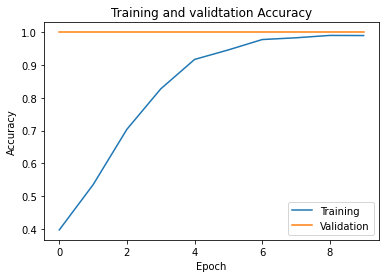

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validtation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])